In [1]:
cd /scratch/gilbreth/basak/ML_/data_inc

/scratch/gilbreth/basak/ML_/data_inc


## Searching for a regression model for Critical Temperature

#### Import required libraries

In [406]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Multiply
# from tensorflow.keras.constraints import unit_norm
from tensorflow.contrib.layers import unit_norm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 

In [407]:
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
# from xgboost import XGBRegressor

In [408]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline
# plt.style.use('dark_background')
# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=True)

#### Load data from file

In [409]:
data = pd.read_csv("SC_data_frac.csv") 

#### Make custom validation set

In [410]:
elements = pd.read_csv("elements_data_2.csv")
indexNames = list(elements[elements["Atomic number"] == 1].index)
indexH = int(elements[elements["Symbol"].isin(["H"])].index[0])
elements.loc[indexNames,"Electro-negativity"] = elements.at[indexH,"Electro-negativity"]

indexNames = list(elements[elements["Electro-negativity"].isin(["NaN"])].index)
elements.loc[indexNames,"Electro-negativity"] = 0.0

In [411]:
colNames = [col[:-2] for col in data if col.endswith('_x')]

data_x["Cumulative Z"] = 0.0
data_x["Cumulative m_a"] = 0.0
data_x["Cumulative X"] = 0.0
data_x["Average Z"] = 0.0
data_x["Average m_a"] = 0.0
data_x["Average X"] = 0.0
data_x["Number of atoms"] = 0.0
for col in colNames:
    indexElem = elements[elements["Symbol"].isin([col])].index[0]
    data_x["Number of atoms"] += data_x[col+"_x"]
    data_x["Cumulative Z"] += data_x[col+"_x"] * float(elements.at[indexElem, "Atomic number"])
    data_x["Cumulative m_a"] += data_x[col+"_x"] * float(elements.at[indexElem, "Atomic weight (u)"])
    data_x["Cumulative X"] += data_x[col+"_x"] * float(elements.at[indexElem, "Electro-negativity"])

data_x["Average Z"] = data_x["Cumulative Z"]/ data_x["Number of atoms"]
data_x["Average m_a"] = data_x["Cumulative m_a"]/ data_x["Number of atoms"]
data_x["Average X"] = data_x["Cumulative X"]/ data_x["Number of atoms"]


In [412]:
colNames = [col[:-2] for col in data if col.endswith('_x')]

data["vec_norm"] = 0.0
data["Scaled T_c"] = data["Critical Temperature"]/data["Critical Temperature"].std()

for col in colNames:
    data[col+"_bool"] = np.array(data[col+"_x"]>0,dtype=int)
    data["vec_norm"] += np.array(data[col+"_x"])**2
data["vec_norm"] = np.array(data["vec_norm"])**(1/2)

for col in colNames:
    data[col+"_vec"] = np.array(data[col+"_x"])/data["vec_norm"]

for col in colNames:
    data[col+"_x_s"] = data[col+"_x"]/data[col+"_x"].std()
    

In [413]:
val_ = data.head(0)
train_ = data.head(0)
test_ = data.head(0)

In [414]:
data_0 = data[data["Critical Temperature"]>0].reset_index(drop=True)
frac_01 = int(len(data_0)*0.1)
val_ = val_.append(data_0.loc[0:frac_01,:])
train_ = train_.append(data_0.loc[frac_01:8*frac_01,:])
val_ = val_.append(data_0.loc[8*frac_01:9*frac_01,:])
test_ = test_.append(data_0.loc[9*frac_01:len(data_0),:])

In [415]:
data_std = data_0.std()

In [416]:
val_X = val_.loc[:,[col for col in data_0 if col.endswith('_bool') or col.endswith('Scaled T_c')]]
test_X = test_.loc[:,[col for col in data_0 if col.endswith('_bool') or col.endswith('Scaled T_c')]]
train_X = train_.loc[:,[col for col in data_0 if col.endswith('_bool') or col.endswith('Scaled T_c')]]

In [417]:
val_y = val_.loc[:,[col for col in data_0 if col.endswith('_p')]]
test_y = test_.loc[:,[col for col in data_0 if col.endswith('_p')]]
train_y = train_.loc[:,[col for col in data_0 if col.endswith('_p')]]

In [418]:
data_std["Critical Temperature"]

28.71537168326799

#### Make the Deep Neural Network
 * Define a sequential model
 * Add some dense layers
 * Use '**relu**' or '**sigmoid**' as the activation function in the hidden layers
 * Use a '**normal**' initializer as the kernal_intializer 
           Initializers define the way to set the initial random weights of Keras layers.
 * We will use mean_absolute_error as a loss function
 * Define the output layer with only one node
 * Use 'linear 'as the activation function for the output layer
 

In [397]:
NN_model = Sequential()

In [398]:
NN_model.add(Dense(256, kernel_initializer='normal', input_dim = train_X.shape[1], activation='relu'))

In [399]:
# NN_model.add(Dense(256, kernel_initializer='normal',activation='sigmoid'))
# # NN_model.add(Dropout(0.5))
# NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
# # NN_model.add(Dropout(0.5))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
# NN_model.add(Dropout(0.5))

In [400]:
from tensorflow.keras.constraints import UnitNorm
from tensorflow.keras import backend as K

from keras.utils.generic_utils import get_custom_objects

def custom_activation(x):
        return x/(1e-7+K.sqrt(K.sum(K.square(x),axis=1,keepdims=True)))

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

NN_model.add(Dense(train_y.shape[1], kernel_initializer='normal',activation='relu'))
# NN_model.add(Activation(custom_activation, name='SpecialActivation'))

In [401]:
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 256)               22784     
_________________________________________________________________
dense_86 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_87 (Dense)             (None, 87)                22359     
Total params: 110,935
Trainable params: 110,935
Non-trainable params: 0
_________________________________________________________________


In [402]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [403]:
NN_model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data = (val_X, val_y), callbacks=callbacks_list)

Train on 8709 samples, validate on 2490 samples
Epoch 1/50
8320/8709 [===========================>..] - ETA: 0s - loss: 0.0929 - mean_absolute_error: 0.0929
Epoch 00001: val_loss improved from inf to 0.10000, saving model to Weights-001--0.10000.hdf5
8709/8709 [==============================] - 4s 441us/step - loss: 0.0930 - mean_absolute_error: 0.0930 - val_loss: 0.1000 - val_mean_absolute_error: 0.1000
Epoch 2/50
8288/8709 [===========================>..] - ETA: 0s - loss: 0.0920 - mean_absolute_error: 0.0920
Epoch 00002: val_loss improved from 0.10000 to 0.09991, saving model to Weights-002--0.09991.hdf5
8709/8709 [==============================] - 1s 71us/step - loss: 0.0920 - mean_absolute_error: 0.0920 - val_loss: 0.0999 - val_mean_absolute_error: 0.0999
Epoch 3/50
8128/8709 [==========================>...] - ETA: 0s - loss: 0.0916 - mean_absolute_error: 0.0916
Epoch 00003: val_loss improved from 0.09991 to 0.09988, saving model to Weights-003--0.09988.hdf5
8709/8709 [===========

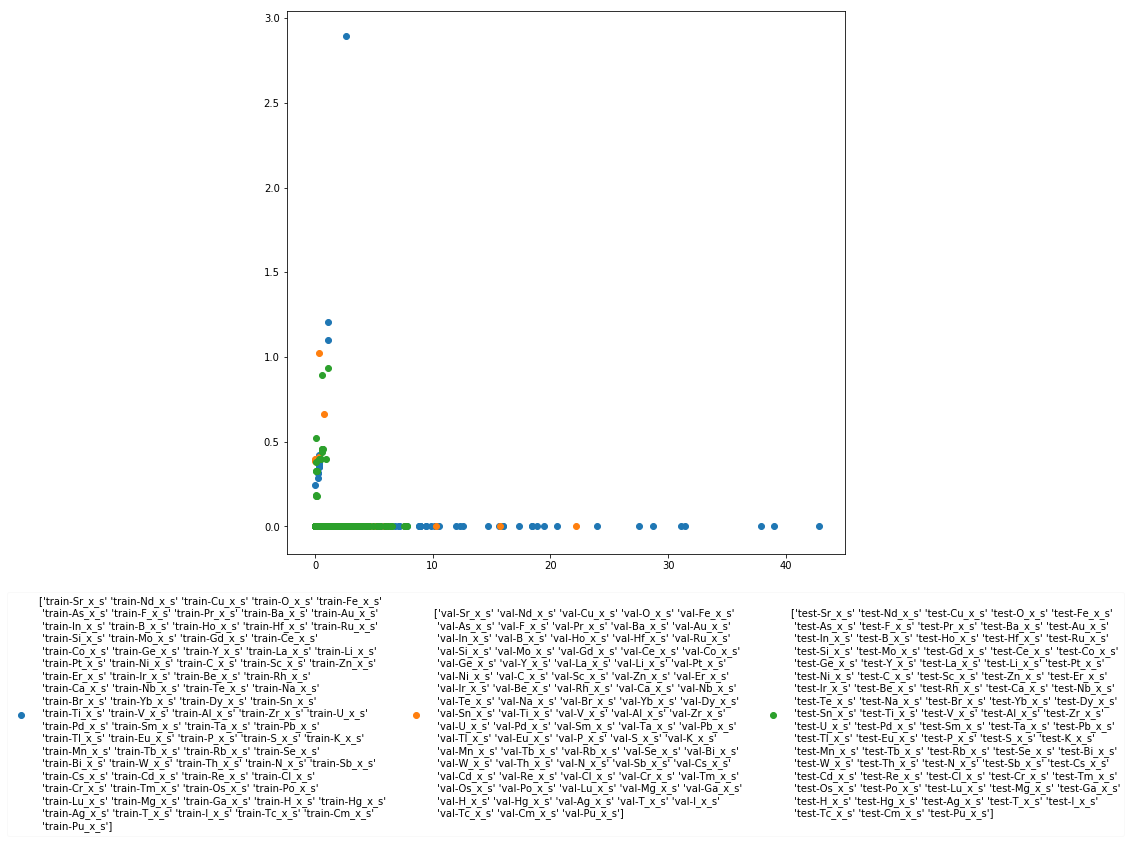

In [404]:
Y_train_pred = NN_model.predict(train_X)
Y_val_pred = NN_model.predict(val_X)
Y_test_pred = NN_model.predict(test_X)
fig = plt.figure( figsize = (10,10) )
ax = fig.add_subplot(1,1,1)
# ax.set_xlim(0,1)
# ax.set_ylim(0,1)
sym=range(87)
# plt.plot(np.linspace(0,1,100),np.linspace(0,0,100),c='r',zorder=1)
plt.scatter(np.array(train_y)[sym].flatten(),np.array(Y_train_pred)[sym].flatten(), label="train-"+train_y.columns.values[sym][:-4])#, s=1000*np.abs(np.array(train_y)[sym].flatten()-np.array(Y_train_pred)[sym].flatten())+1)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), fancybox=True, framealpha=0.1, ncol=10)
plt.scatter(np.array(val_y)[sym].flatten(),np.array(Y_val_pred)[sym].flatten(), label="val-"+val_y.columns.values[sym][:-4])#, s=1000*np.abs(np.array(val_y)[sym].flatten()-np.array(Y_val_pred)[sym].flatten())+1)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), fancybox=True, framealpha=0.1, ncol=10)
plt.scatter(np.array(test_y)[sym].flatten(),np.array(Y_test_pred)[sym].flatten(), label="test-"+test_y.columns.values[sym][:-4])#, s=1000*np.abs(np.array(test_y)[sym].flatten()-np.array(Y_test_pred)[sym].flatten())+1)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), fancybox=True, framealpha=0.1, ncol=10)
plt.show()

In [164]:
np.min(np.sum(Y_test_pred**2,axis=1))

0.99999964

### Try Random Forest Regressor

In [419]:
model = RandomForestRegressor()
model.fit(train_X.append(val_X),train_y.append(val_y))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [420]:
predicted_Tc = model.predict(test_X)
MAE = mean_absolute_error(test_y , predicted_Tc)
print('Random forest validation MAE = ', MAE)

Random forest validation MAE =  0.0013814736534495553


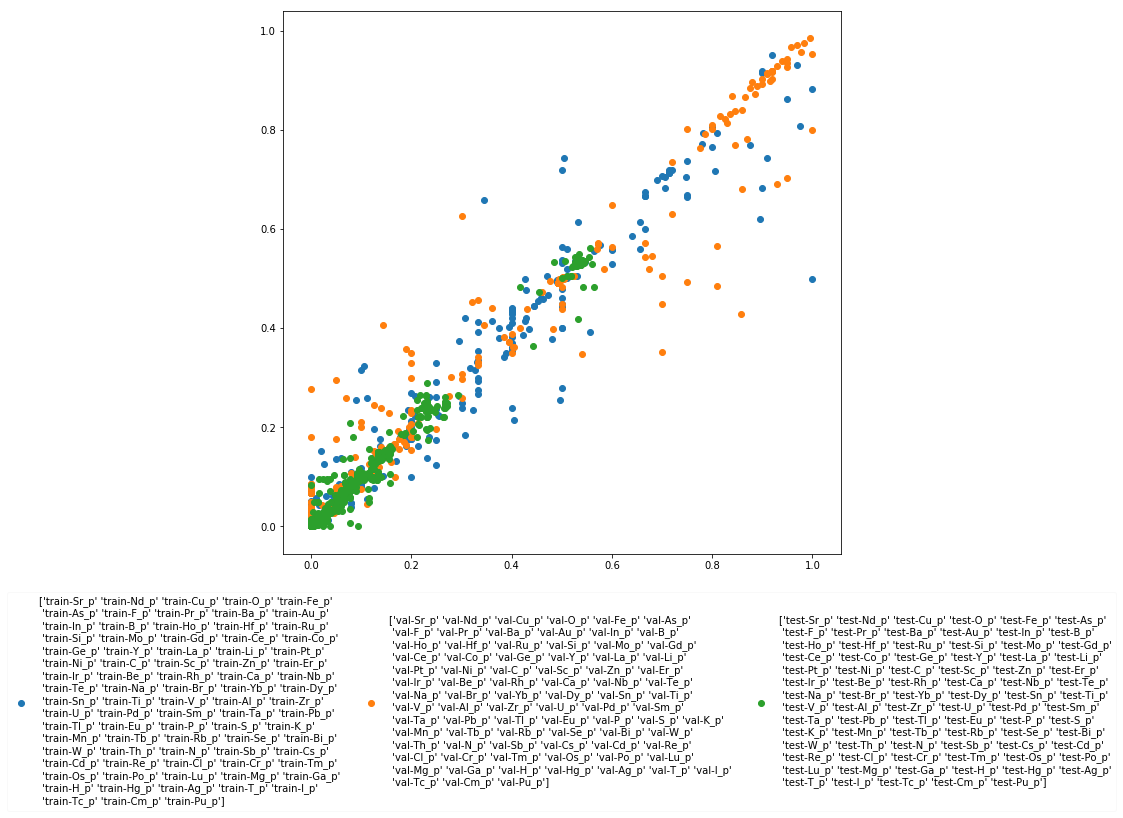

In [421]:
Y_train_pred = model.predict(train_X)
Y_val_pred = model.predict(val_X)
Y_test_pred = model.predict(test_X)
fig = plt.figure( figsize = (10,10) )
ax = fig.add_subplot(1,1,1)
# ax.set_xlim(0,10)
# ax.set_ylim(0,10)
sym=range(87)
# plt.plot(np.linspace(0,1,100),np.linspace(0,0,100),c='r',zorder=1)
plt.scatter(np.array(train_y)[sym].flatten(),np.array(Y_train_pred)[sym].flatten(), label="train-"+train_y.columns.values[sym][:-4])#, s=1000*np.abs(np.array(train_y)[sym].flatten()-np.array(Y_train_pred)[sym].flatten())+1)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), fancybox=True, framealpha=0.1, ncol=10)
plt.scatter(np.array(val_y)[sym].flatten(),np.array(Y_val_pred)[sym].flatten(), label="val-"+val_y.columns.values[sym][:-4])#, s=1000*np.abs(np.array(val_y)[sym].flatten()-np.array(Y_val_pred)[sym].flatten())+1)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), fancybox=True, framealpha=0.1, ncol=10)
plt.scatter(np.array(test_y)[sym].flatten(),np.array(Y_test_pred)[sym].flatten(), label="test-"+test_y.columns.values[sym][:-4])#, s=1000*np.abs(np.array(test_y)[sym].flatten()-np.array(Y_test_pred)[sym].flatten())+1)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), fancybox=True, framealpha=0.1, ncol=10)
plt.show()

In [424]:
test_X_200plus = test_X.head(0)

for i,t in enumerate(range(50,200,10)):
    test_X_200plus.loc[i,"Scaled T_c"] = t/data_std["Critical Temperature"]
    test_X_200plus.loc[i,"Critical Temperature"] = t
    test_X_200plus.loc[i,[col for col in data if col.endswith("_bool") ]] = 1

# test_X_200plus

In [425]:
Y_200plus_pred

array([[0.02928571, 0.00286123, 0.05505853, ..., 0.        , 0.        ,
        0.        ],
       [0.02928571, 0.00286123, 0.05505853, ..., 0.        , 0.        ,
        0.        ],
       [0.02928571, 0.00286123, 0.05505853, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02928571, 0.00286123, 0.05505853, ..., 0.        , 0.        ,
        0.        ],
       [0.02928571, 0.00286123, 0.05505853, ..., 0.        , 0.        ,
        0.        ],
       [0.02928571, 0.00286123, 0.05505853, ..., 0.        , 0.        ,
        0.        ]])

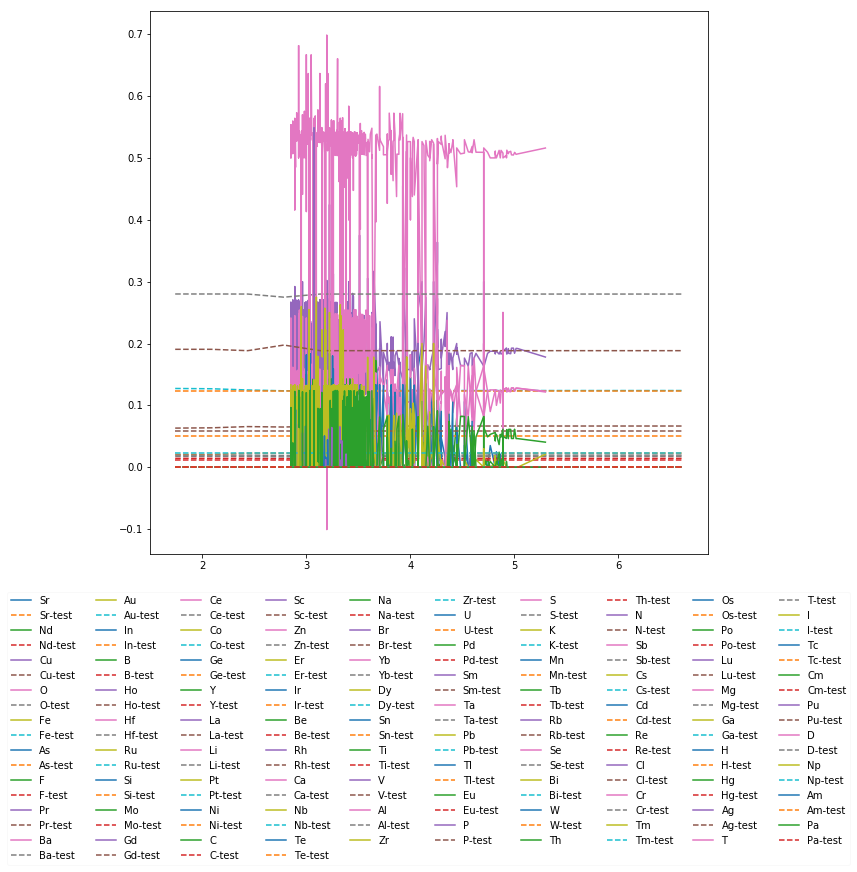

In [426]:
Y_200plus_pred = model.predict(test_X_200plus)
plt.figure(figsize=(10,10))
for i,sym in enumerate([col for col in data if col.endswith("_bool")]):
    plt.plot(test_["Scaled T_c"],test_.loc[:,sym[:-5]+"_p"],label=sym[:-5])
    plt.plot(test_X_200plus["Scaled T_c"],Y_200plus_pred[:,i],label=sym[:-5]+"-test",linestyle='--')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), fancybox=True, framealpha=0.1, ncol=10)
plt.show()

In [341]:
test_1 = test_y.head(0)

for i in enumerate([col for col in test_y if col.endswith("_p")]):
    if test_y[test_y[sym]<0].shape[0]>0:
        culprit[]
        
data[data["Ba_p"]<0]

Compound  Critical Temperature  Sr_x  Nd_x  Cu_x   O_x  Fe_x  \
15714  Sm1Ba-1Cu3O6.94                  86.3   0.0   0.0   3.0  6.94   0.0   

       As_x  F_x  Pr_x   ...    Ag_vec  T_vec  I_vec  Tc_vec  Cm_vec  Pu_vec  \
15714   0.0  0.0   0.0   ...       0.0    0.0    0.0     0.0     0.0     0.0   

       D_vec  Np_vec  Am_vec  Pa_vec  
15714    0.0     0.0     0.0     0.0  

[1 rows x 352 columns]

In [91]:
X_train.to_csv('x_train.csv',index=None,header=True)
Y_train.to_csv('y_train.csv',index=None,header=True)
X_test.to_csv('x_test.csv',index=None,header=True)
Y_test.to_csv('y_test.csv',index=None,header=True)

### Max/Min difference in electronegativity of constituent elements

In [ ]:
colNames = [col[:-2] for col in data if col.endswith('_x')]

for row in data.index:
    e_max = 0.0
    e_min = 0.0
    print("\r",row,end='       ')
    for i,col1 in enumerate(colNames):
        indexElem1 = elements[elements["Symbol"].isin([col1])].index[0]
        for j,col2 in enumerate(colNames):
            if j<=i:
                continue
            indexElem2 = elements[elements["Symbol"].isin([col2])].index[0]
            if data.at[row,col1]>0 and data.at[row,col2]>0:
                e_1 = float(elements.at[indexElem1, "Electro-negativity"]) * data.at[row,col1+"_x"]
                e_2 = float(elements.at[indexElem2, "Electro-negativity"]) * data.at[row,col2+"_x"]
                e_dif = abs(e_1-e_2)
                if e_max < e_dif:
                    e_max = e_dif 
                if e_min > e_dif:
                    e_min = e_dif
                
                